In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(0.01,0.01))
plt.gca().set_visible(False)

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [3]:
os.listdir("/Users/acer/Downloads/Deep learning in cv/Exercise 2/data/data/train")

['car', 'not_car']

In [4]:
train_path = "/Users/acer/Downloads/Deep learning in cv/Exercise 2/data/data/train"
test_path = "/Users/acer/Downloads/Deep learning in cv/Exercise 2/data/data/test"

In [5]:
train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = False)

In [16]:
def mean_std(loader):
    mean = 0.
    std = 0.
    total_image_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std +=images.std(2).sum(0)
        total_image_count += image_count_in_a_batch
        
    mean /= total_image_count
    std /= total_image_count
    
    return mean, std

In [17]:
mean_std(train_dataloader)

(tensor([0.4887, 0.4887, 0.4761]), tensor([0.1482, 0.1395, 0.1342]))

In [18]:
mean = [0.4887, 0.4887, 0.4761]
std = [0.1482, 0.1395, 0.1342]


train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])


In [19]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)


In [20]:
def show_tranformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 6)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1])


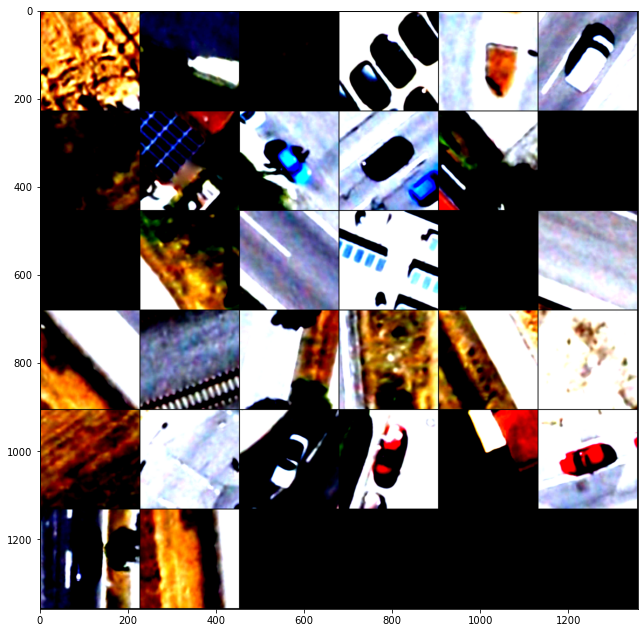

In [21]:
show_tranformed_images(train_dataset)

In [23]:
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(32 * 110 * 110, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
#initilize the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=387200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [28]:
#optimizer and loss function

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 40
batch_size = 32
#dataloader = get_data_loader(data_dir, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        # Print mini-batch statistics
        if (i + 1) % 50 == 0:
            mini_batch_loss = running_loss / total_samples
            mini_batch_accuracy = correct_predictions / total_samples
            print(f"Minibatch Loss: {mini_batch_loss:.4f}  Accuracy: {mini_batch_accuracy:.4f}")

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_predictions / len(train_dataloader.dataset)

    print(f"Loss: {epoch_loss:.4f}  Accuracy: {epoch_accuracy:.4f}")
    print()

Epoch 1/40
--------------------------------------------------
Minibatch Loss: 0.0495  Accuracy: 0.9794
Minibatch Loss: 0.0538  Accuracy: 0.9791
Loss: 0.0493  Accuracy: 0.9805

Epoch 2/40
--------------------------------------------------
Minibatch Loss: 0.0163  Accuracy: 0.9975
Minibatch Loss: 0.0185  Accuracy: 0.9944
Loss: 0.0178  Accuracy: 0.9945

Epoch 3/40
--------------------------------------------------
Minibatch Loss: 0.0179  Accuracy: 0.9956
Minibatch Loss: 0.0151  Accuracy: 0.9962
Loss: 0.0126  Accuracy: 0.9969

Epoch 4/40
--------------------------------------------------
Minibatch Loss: 0.0061  Accuracy: 0.9988
Minibatch Loss: 0.0091  Accuracy: 0.9966
Loss: 0.0095  Accuracy: 0.9964

Epoch 5/40
--------------------------------------------------
Minibatch Loss: 0.0098  Accuracy: 0.9962
Minibatch Loss: 0.0083  Accuracy: 0.9972
Loss: 0.0076  Accuracy: 0.9974

Epoch 6/40
--------------------------------------------------
Minibatch Loss: 0.0063  Accuracy: 0.9981
Minibatch Loss: 0

In context of our training model, when a network goes over a complete dataset once then it can be said as one epoch. Since we are not processing our entire training data in one forward pass but passing number of batches and performing one pass over each pass which is then optimised through back propagation. So the number of forwarding pass that a network has to make to complete one epoch will be the iterations.



In [29]:
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = train_transforms)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Print the results
print("Classification Report:")
print(classification_rep)
print()
print("Confusion Matrix:")
print(confusion_mat)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       400
           1       0.98      0.99      0.98       946

    accuracy                           0.98      1346
   macro avg       0.97      0.97      0.97      1346
weighted avg       0.98      0.98      0.98      1346


Confusion Matrix:
[[378  22]
 [ 11 935]]


torch.Size([32, 3, 224, 224]) torch.Size([32])


def train_nn(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs):

def evaluate_model_on_test_set(model, test_dataloader):

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


resnet18_model = models.reset18(pretrained=False)
num_features = resnet18_model.fc.in_featues
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_features, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [31]:
from torchvision.models import resnet18
# Define the transforms for preprocessing
transform = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

# Load the pre-trained ResNet18 model
model = resnet18(pretrained=True)
num_classes = len(train_dataset.classes)

# Replace the last fully connected layer with a new one (to match the number of classes in dataset)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

    # Calculate average loss
    epoch_loss = running_loss / len(train_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

C:\Users\acer\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\acer/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.64MB/s]


Epoch 1/10, Loss: 0.0529
Epoch 2/10, Loss: 0.0068
Epoch 3/10, Loss: 0.0053
Epoch 4/10, Loss: 0.0047
Epoch 5/10, Loss: 0.0054
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0003
Epoch 8/10, Loss: 0.0003
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0005


In [32]:
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Print the results
print("Classification Report:")
print(classification_rep)
print()
print("Confusion Matrix:")
print(confusion_mat)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       1.00      1.00      1.00       946

    accuracy                           1.00      1346
   macro avg       0.99      1.00      0.99      1346
weighted avg       1.00      1.00      1.00      1346


Confusion Matrix:
[[398   2]
 [  4 942]]
